In [1]:
library(INLA)


Loading required package: Matrix

Loading required package: foreach

Loading required package: parallel

Loading required package: sp

This is INLA_22.05.07 built 2022-05-07 09:52:03 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - To enable PARDISO sparse library; see inla.pardiso()



In [2]:
n_arms = 4
y = c(0, 1, 9, 10)
n = c(20, 20, 35, 35)
df <- data.frame(y = y, gid = (1:n_arms), const=rep(1, n_arms))

mu_0 = -1.34
mu_sig2 = 100.0
sig2_alpha = 0.0005
sig2_beta = 0.000005
logit_p1 = rep(qlogis(0.3), n_arms)


In [3]:
# there's a great R-INLA vignette that explains how to use `inla.rgeneric.define(...)`!
# this is following the instructions there basically to the letter.
berry.model = function(
        cmd = c("graph", "Q", "mu", "initial", "log.norm.const", "log.prior", "quit"),
        theta = NULL)
{
    d = 4
    mu_sig2 = 100.0
    sig2_alpha = 0.0005
    sig2_beta = 0.000005
    envir = parent.env(environment())
    interpret.theta = function () {
        return (list(prec = exp(theta[1L])))
    }
    graph = function(){
        return (matrix(1, nrow=d, ncol=d))
    }
    Q = function() {
        p = interpret.theta()
        sig2 = 1.0 / p$prec
        cov = matrix(mu_sig2, nrow=d, ncol=d) + sig2 * Diagonal(d)
        q = solve(cov)
        return (inla.as.sparse(q))
    }
    mu = function() { return (numeric(0))  }
    log.norm.const = function() { return (numeric(0)) }
    log.prior = function() { 
        p = interpret.theta()$prec
        val = dgamma(p, shape=sig2_alpha, rate=sig2_beta, log=TRUE) + theta[1L]
        return (val)
    }
    initial = function() { 
        return (rep(1, 1)) 
    }
    quit = function() { return (invisible()) }

    if (!length(theta)) {
        theta = initial()
    }

    val = do.call(match.arg(cmd), args = list())

    return (val)
}

In [4]:

model = inla.rgeneric.define(berry.model)
use_custom = TRUE

# both these models should be producing the same output but there's noise
# that's added by the non-custom version because of the large values added to
# the diagonal of the precision matrix.
if (use_custom) {
    expr = y ~ 0 + f(gid, model=model)
    get_mode = function (x) {
        out = x[5:8] + mu_0 + logit_p1
        return (out)
    }
} else {
    expr = y ~ 0 + f(
        gid, 
        model = "iid",
        hyper = list(prec = list(param = c(sig2_alpha, sig2_beta)))
    ) + f(
        const,
        model="iid",
        hyper = list(prec = list(initial=1.0 / mu_sig2, fixed=TRUE))
    )
    get_mode = function (x) {
        out = x[5:8] + mu_0 + logit_p1 + x[9]
        return (out)
    }
}
result <- inla(
    expr,
    data=df,
    Ntrials = n,
    family = "binomial",
    offset = mu_0 + logit_p1,
    control.compute=list(
        config=TRUE,
        return.marginals=TRUE,
        return.marginals.predictor=TRUE
    ),
    control.inla=list(strategy="gaussian"),
    verbose=TRUE
)
summary(result)

Warning message in inla.model.properties.generic(inla.trim.family(model), mm[names(mm) == :
“Model 'rgeneric' in section 'latent' is marked as 'experimental'; changes may appear at any time.
  Use this model with extra care!!! Further warnings are disabled.”
Warning message in .recacheSubclasses(def@className, def, env):
“undefined subclass "numericVector" of class "Mnumeric"; definition not updated”



Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " blas.num.threads = blas.num.threads, keep = keep, 


$sig2_mode
[1] 2.450777

$latent_mode
[1] -3.5062375 -2.7036146 -1.1201968 -0.9799049

$sig2_grid
$sig2_grid[[1]]
[1] 2.450777

$sig2_grid[[2]]
[1] 0.0891496

$sig2_grid[[3]]
[1] 808.8663

$sig2_grid[[4]]
[1] 2.249874e-05

$sig2_grid[[5]]
[1] 29.42336

$sig2_grid[[6]]
[1] 154.2711

$sig2_grid[[7]]
[1] 5.151744e-05

$sig2_grid[[8]]
[1] 12.84979

$sig2_grid[[9]]
[1] 0.03893348

$sig2_grid[[10]]
[1] 0.0001179643

$sig2_grid[[11]]
[1] 1.070305

$sig2_grid[[12]]
[1] 0.2041341

$sig2_grid[[13]]
[1] 0.007425591

$sig2_grid[[14]]
[1] 0.001416246

$sig2_grid[[15]]
[1] 9.825667e-06

$sig2_grid[[16]]
[1] 5.611772

$sig2_grid[[17]]
[1] 67.37338

$sig2_grid[[18]]
[1] 353.2487

$sig2_grid[[19]]
[1] 0.00324291

$sig2_grid[[20]]
[1] 0.0002701137

$sig2_grid[[21]]
[1] 1.874001e-06

$sig2_grid[[22]]
[1] 0.4674247

$sig2_grid[[23]]
[1] 0.01700306

$sig2_grid[[24]]
[1] 0.0006185042

$sig2_grid[[25]]
[1] 4.291073e-06

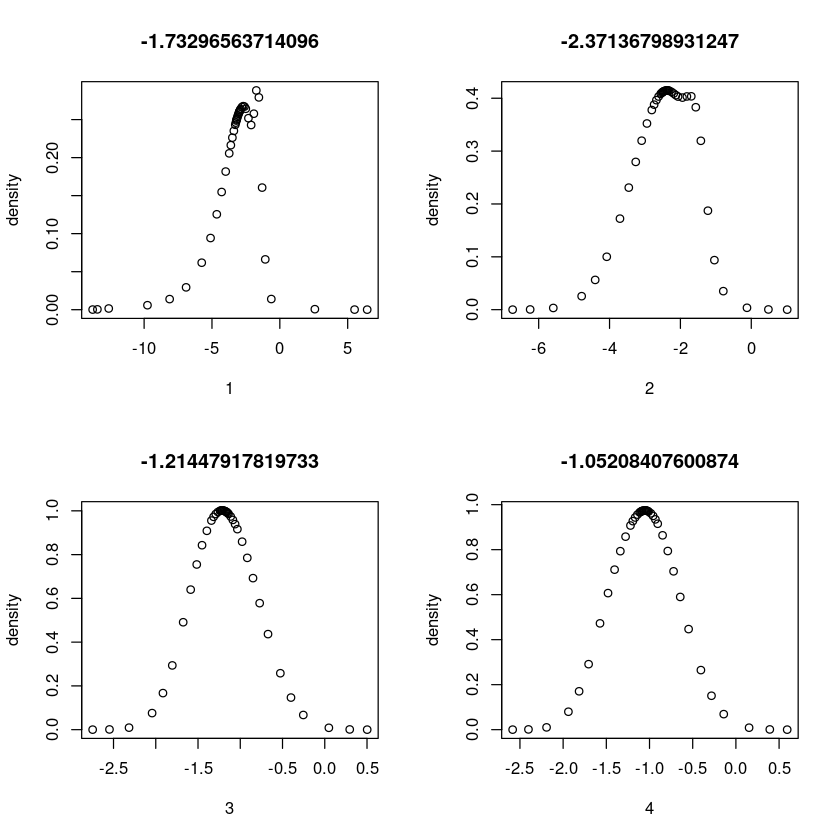

In [5]:
c_sig2 = c()
mean = c()
for (i in 1:length(result$misc$configs$config)) {
    c_sig2[[i]] = exp(-result$misc$configs$config[[i]]["theta"][[1]][[1]])
    mean[[i]] = get_mode(result$misc$configs$config[[i]]["mean"][[1]])
}
list(sig2_mode = exp(-result$mode$theta[[1]]), latent_mode=get_mode(result$mode$x), sig2_grid=c_sig2)

hyperpar_data = result$marginals.hyperpar
write.csv(hyperpar_data[[1]], "hyperpar_data2.csv")
# Plot marginal PDFs.
# These will depend heavily on hyperparameter priors which I have just left
# default for now.
par(mfrow=c(2,2))
for (i in 1:4) {
    theta_i <- result$marginals.linear.predictor[[i]][,1]
    density <- result$marginals.linear.predictor[[i]][,2]
    plot(theta_i, density, main=theta_i[which.max(density)], xlab=i)
    # abline(v=mean(t_i), col="blue")
}

In [6]:
# grid_opts = c("ccd", "grid", "eb")
grid_opts = c("grid")
m.strategy <- lapply(c("gaussian", "simplified.laplace", "laplace"), 
  function(st) {
    return(lapply(grid_opts, function(int.st) {
      return (inla(
          expr,
          data=df,
          Ntrials = n,
          family = "binomial",
          offset = mu_0 + logit_p1,
          control.compute=list(
              config=TRUE,
              return.marginals=TRUE,
              return.marginals.predictor=TRUE
          ),
          control.inla = list(
            strategy = st,
            int.strategy = int.st,
            npoints=100,
            cutoff=1e-7
          )
        ))
    }))
})

Loading required package: viridisLite

Warning message:
“Removed 21 rows containing missing values (geom_point).”
Warning message:
“Removed 21 row(s) containing missing values (geom_path).”


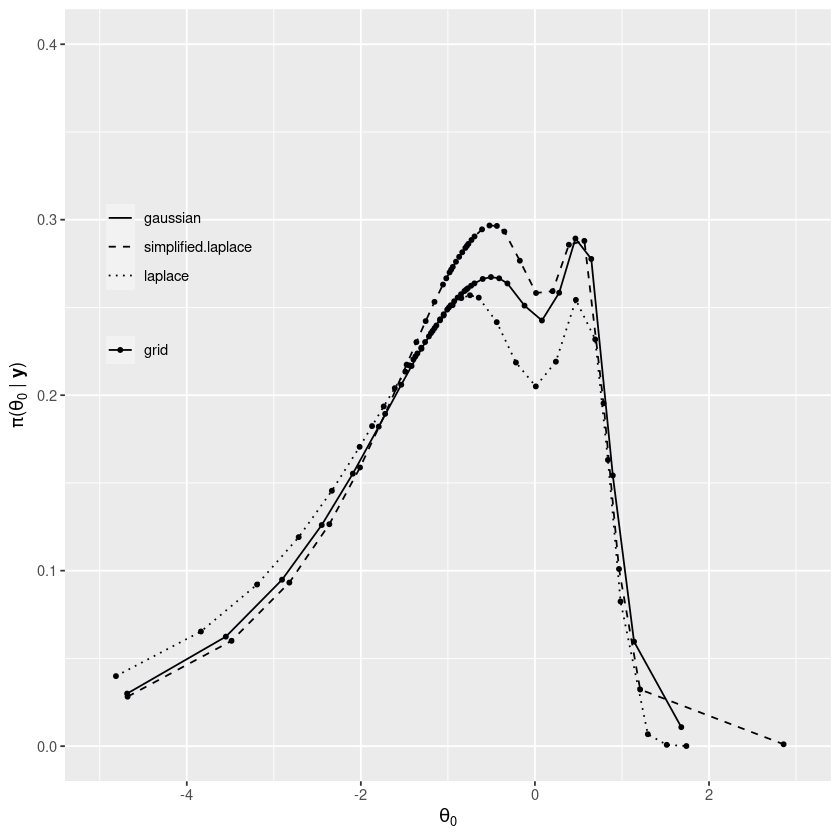

In [7]:
# took this snippet from the source of https://becarioprecario.bitbucket.io/inla-gitbook/ch-INLA.html
library(ggplot2)
library("viridis")
intst.colors <- magma(4)

marg.theta <- lapply(m.strategy, function(X) {
  do.call(rbind, lapply(X, function(Y) {Y$marginals.random[[1]][[1]]}))
})
marg.theta <- as.data.frame(do.call(rbind, marg.theta))
ntheta1 = dim(m.strategy[[1]][[1]]$marginals.random[[1]][[1]])[[1]]
marg.theta$strategy <- rep(c("gaussian", "simplified.laplace", "laplace"),
  each = length(grid_opts) * ntheta1)
marg.theta$strategy <- factor(marg.theta$strategy,
  levels = c("gaussian", "simplified.laplace", "laplace"))
marg.theta$int.strategy <- rep(rep( grid_opts, each = ntheta1), 3)
marg.theta$int.strategy <- factor(marg.theta$int.strategy,
  levels = grid_opts)


ggplot(marg.theta, aes(x = x, y = y, linetype = strategy, colour = int.strategy)) +
    geom_point(size=1) + 
    geom_line(size=0.5) +
    xlim(-5.0, 3.0) + ylim(0, 0.4) +
    xlab(expression(theta[0])) +
    ylab(expression(paste(pi, "(", theta[0], " | ", bold(y), ")")) ) +
    scale_linetype_manual(values = c("solid", "dashed", "dotted")) +
    scale_colour_manual(values = intst.colors) +
    theme(legend.position = c(0.15, 0.65),
        legend.background = element_rect(fill = "transparent"),
        legend.title = element_blank())

In [8]:
write.csv(marg.theta, "latent_data.csv")